In [106]:
# import libraries
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
from numpy.random import randn
import os
import seaborn as sns
import keras
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose, Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [93]:
# config
noise_dimension = 100  
batch_size = 64 
width, height, channels = 128, 128, 1

In [94]:
main_dir = "./data/brain_tumor_dataset/yes"

In [95]:
# loading the dataset => resize images to 128*128*3
images = []
for i in os.listdir(main_dir):
    img = os.path.join(main_dir,i)
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128,128))
    images.append(img)      
dataset = np.array(images)

In [96]:
print(dataset.shape)
X_train = dataset
# normalize => scale from [0,255] to [-1,1] => Generator uses the "tanh" activation so we need to rescale original images to -1 to 1 to match the output of generator
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
# reshape
X_train = X_train.reshape(-1, width, height, channels)

(155, 128, 128)


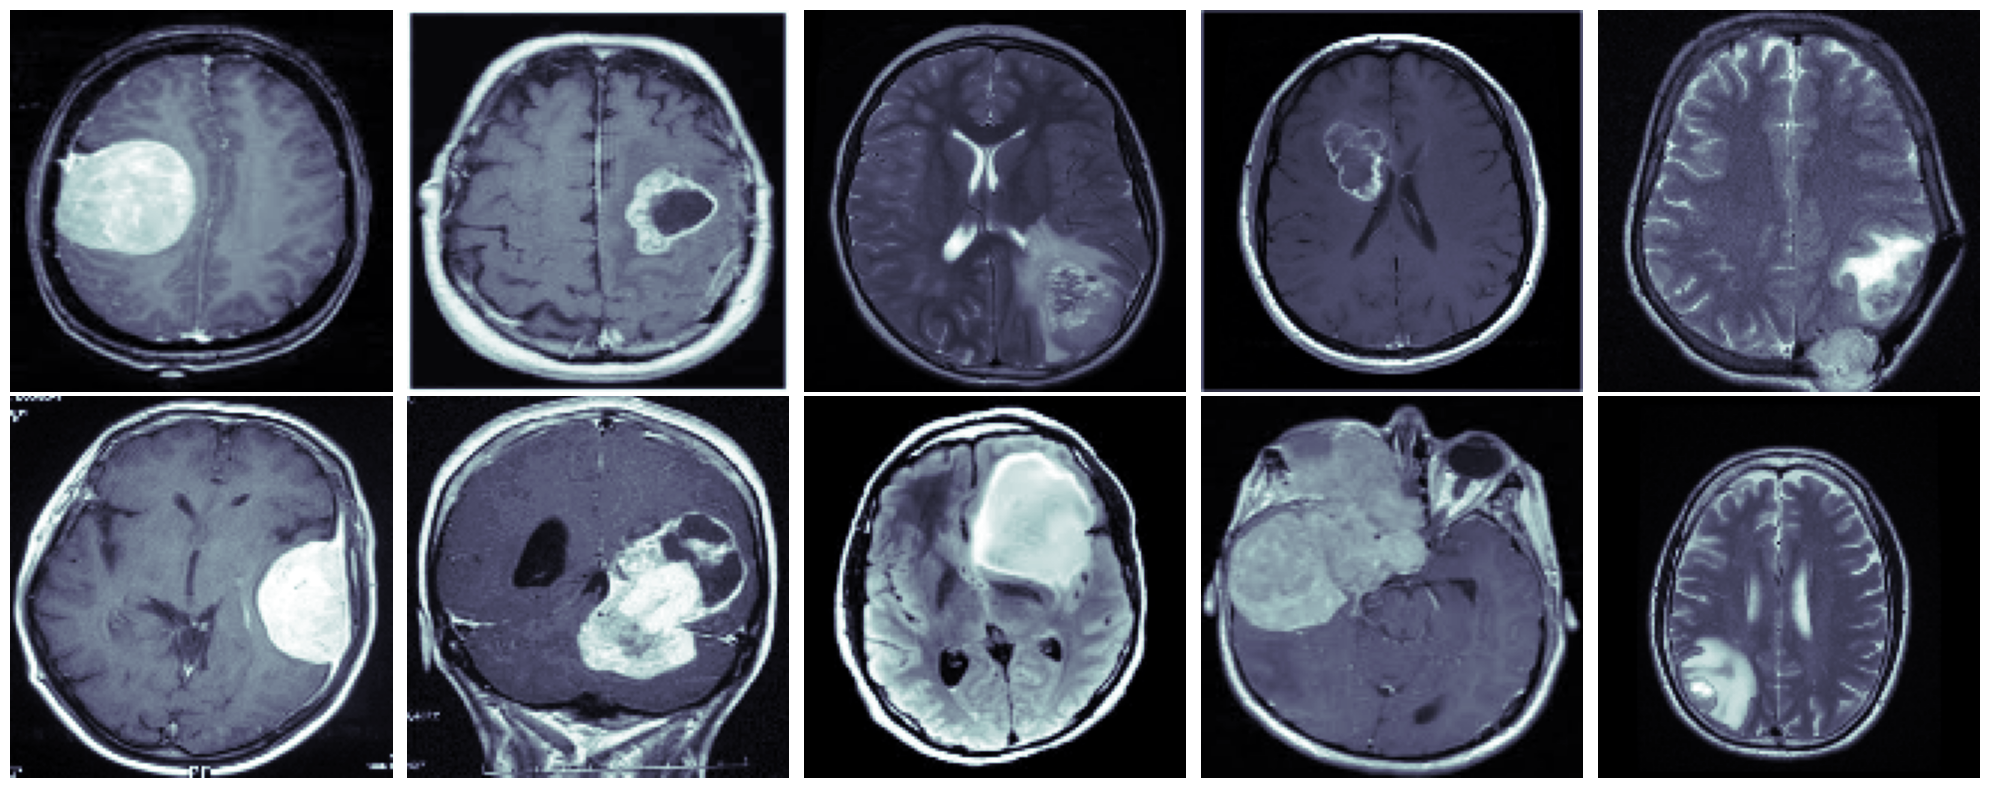

In [82]:
plt.figure(figsize=(20,8))
for i in range(10):
    axs = plt.subplot(2,5,i+1)
    plt.imshow(X_train[i], cmap="bone")
    plt.axis('off')
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

In [97]:
# Input: random noise (Latent Vector) => 1D array of size 100 
# Output: produces image(here: 128x128)
def func_generator(noise_dimension):
    n_nodes = 256*32*32
    model = Sequential([
        # the first layes is a 1-D vector so it's a dense layer (not a 2-D convolutional layer)
        # reshape input latent vector into 32x32 as a starting point 
        # there are 256*32*32 nodes in the Dense layes and they should be upscaled to 128x128x1 image for output
        Dense(n_nodes, input_dim=noise_dimension), 
        LeakyReLU(alpha=0.2),
        Reshape((32, 32, 256)),

        # upsample to 64x64
        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        # upsample to 128x128
        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        # generate 128*128*1 + the generated images have the value between -1 and 1 (tanh)
        Conv2D(1, (4, 4), padding='same', activation='tanh')]) 
    
        # model is not compiled as it's not directly trained like the discriminator, generator is trained via GAN combination model
    return model

G_model = func_generator(noise_dimension)
G_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 262144)            26476544  
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 262144)            0         
                                                                 
 reshape_5 (Reshape)         (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose_10 (Conv2  (None, 64, 64, 128)       524416    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 conv2d_transpose_11 (Conv2  (None, 128, 128, 128)     262272    
 DTranspose)                                         

In [98]:
# Discriminator is responsible for classifying the generated images as fake or real
# Binary classification (1 or 0) => sigmoid
# Input: fake / Real Image
# Output: the probability of the image being real
def func_discriminator():
    model = Sequential([
        Conv2D(64, (3, 3), padding='same',input_shape=(width, height, channels)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid", input_shape=(width, height, channels))])
    
    model.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    return model

D_model = func_discriminator()
D_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_29 (Conv2D)          (None, 16, 16, 256)     

In [99]:
# a batch of random real samples to train the GAN on a half batch of real images and another half batch of fake images
# For real images (label 1) and for fake ones (label 0)
def real_samples(dataset, n_samples):
	# choose random images
	indx = np.random.randint(0, dataset.shape[0], n_samples) # dataset.shape = 155
	X = dataset[indx]
	# generate class labels
	y = np.ones((n_samples, 1)) # label 1 to fool discriminator that they are real
	return X, y

In [100]:
# generate points
def generate_latent_points(noise_dimension, n_samples):
	x_input = randn(noise_dimension * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, noise_dimension)
	return x_input

In [101]:
def fake_samples(generator, noise_dimension, n_samples):
    X_input = generate_latent_points(noise_dimension, n_samples) # generating points in latent space
    X = generator.predict(X_input) # generating fake samples
    y = np.zeros((n_samples, 1))  # labels 0 as these samples are fake
    return X, y

In [102]:
# the combined generator and discriminator model, for training and updating the generator
# Discriminator is trained separately (remain constant) 
def gan(generator, discriminator):
	discriminator.trainable = False 
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	
	model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model

In [103]:
def func_train(gen_model, dis_model, gan_model, dataset, noise_dimension, num_epochs=50, num_batch=64):
	batch_per_epoch = int(dataset.shape[0] / num_batch)
	half_batch = int(num_batch / 2)  # train the discriminator on real and fake images (half batch each)
	
	for i in range(num_epochs):
		for j in range(batch_per_epoch):
            
			X_real, y_real = real_samples(dataset, half_batch)

			d_loss_real, d_acc_real = dis_model.train_on_batch(X_real, y_real)  # update discriminator model weights
		
			X_fake, y_fake = fake_samples(gen_model, noise_dimension, half_batch)

			d_loss_fake, d_acc_fake = dis_model.train_on_batch(X_fake, y_fake) # update discriminator model weights
            
			X_gan = generate_latent_points(noise_dimension, num_batch)
             
			y_gan = np.ones((num_batch, 1))
            
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			
			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, batch_per_epoch, d_loss_real, d_loss_fake, g_loss))

	gen_model.save('Brain_MRI_generator.h5')

In [104]:
dis_model = func_discriminator()
gen_model = func_generator(noise_dimension)
gan_model = gan(gen_model, dis_model)
dataset = X_train
func_train(gen_model, dis_model, gan_model, dataset, noise_dimension)

1/1 [==============================] - 1s 968ms/step
Epoch>1, Batch 1/2, d1=0.695, d2=0.695 g=0.693
1/1 [==============================] - 1s 956ms/step
Epoch>1, Batch 2/2, d1=0.582, d2=0.707 g=0.680
1/1 [==============================] - 1s 967ms/step
Epoch>2, Batch 1/2, d1=0.448, d2=0.796 g=0.612
1/1 [==============================] - 1s 979ms/step
Epoch>2, Batch 2/2, d1=0.279, d2=1.207 g=0.491
1/1 [==============================] - 1s 1s/step
Epoch>3, Batch 1/2, d1=0.279, d2=1.344 g=0.520
1/1 [==============================] - 1s 1s/step
Epoch>3, Batch 2/2, d1=0.394, d2=0.928 g=0.683
1/1 [==============================] - 1s 1s/step
Epoch>4, Batch 1/2, d1=0.521, d2=0.677 g=0.870
1/1 [==============================] - 1s 1s/step
Epoch>4, Batch 2/2, d1=0.532, d2=0.541 g=1.087
1/1 [==============================] - 1s 971ms/step
Epoch>5, Batch 1/2, d1=0.407, d2=0.471 g=1.320
1/1 [==============================] - 1s 1s/step
Epoch>5, Batch 2/2, d1=0.333, d2=0.669 g=1.430
1/1 [==========

1/1 [==============================] - 0s 402ms/step


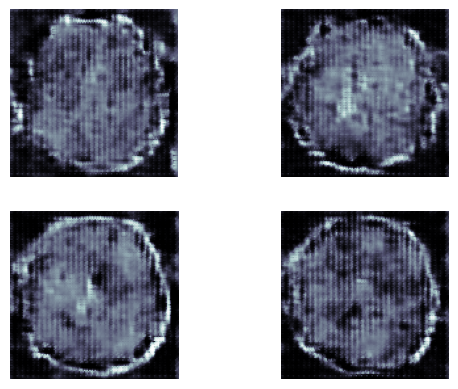

In [109]:
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :],cmap="bone")
	plt.show()

model = load_model('Brain_MRI_generator.h5') 
latent_points = generate_latent_points(100, 10)
X = model.predict(latent_points)
# rescale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
show_plot(X, 2)